(923, 960, 3)
120 sample png files were detected
['/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_038-tile-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_053-tile-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_007-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_010-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_011-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_008-tile-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_041-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_005-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_049-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_014-p1c.png', '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_021-p1c.png', '/home/dagutman/devel/multirater-viewer/imag

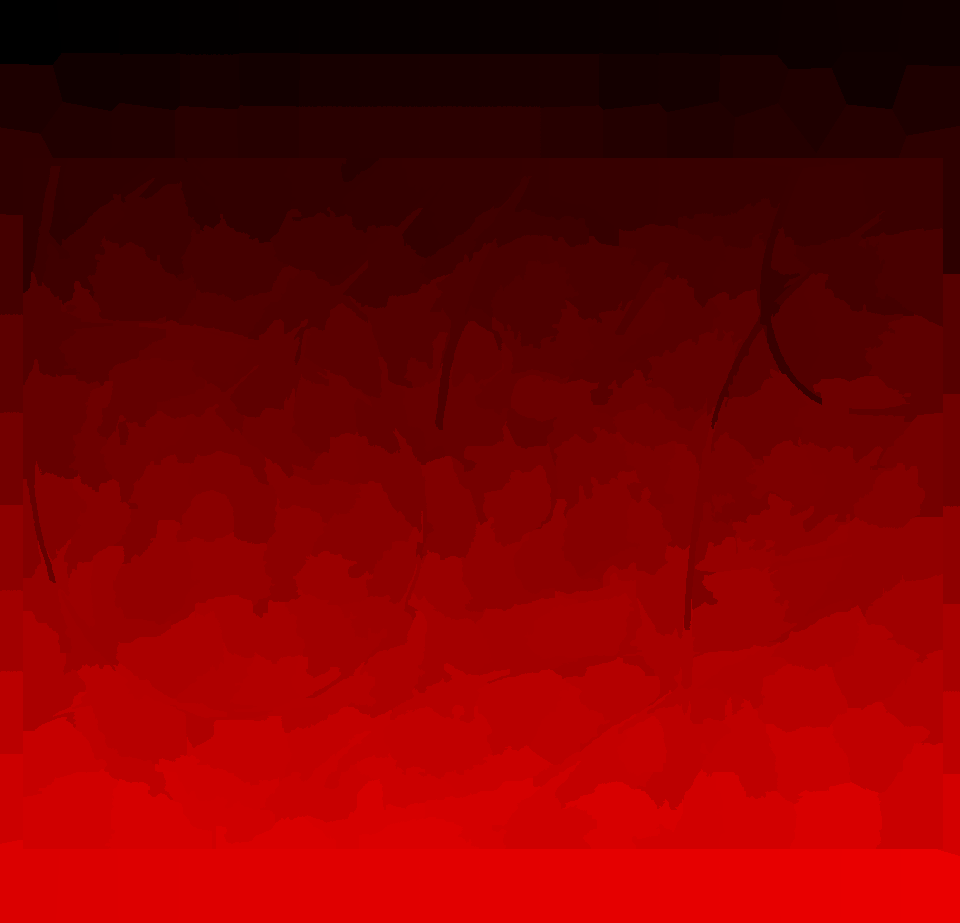

In [3]:
from IPython.display import Image
sample_png_tile =  '/home/dagutman/devel/multirater-viewer/images/base_img/UDA2_pilot_060-tile-p1c.png'
base_img_dir = '/home/dagutman/devel/multirater-viewer/images/base_img/'
from PIL import Image as PIL_Image
import image_processing as ip
Image(sample_png_tile)
import cv2,os
import glob
img = cv2.imread(sample_png_tile)
print img.shape

png_image_list = glob.glob(base_img_dir+'*.png')  ## This contains tile and background images
print len(png_image_list),"sample png files were detected"
print png_image_list
Image(sample_png_tile)

In [7]:
import json

annotated_image_list = []  ## I am going to push a list of dictionaries.. each item is a specific image which then contains all the metadata for that image

for img in png_image_list:
    if 'tile' not in img:

        img_filename = os.path.basename(img).replace('-p1c.png','')
        filename_url = 'images/base_img/'+os.path.basename(img)
        tile_img_url = 'images/base_img/' + img_filename + '-tile-p1c.png'
        
        
        ### GENERATE THE CONTOUR FILE FOR THIS AS WELL
        svg_output_file = 'data/'+img_filename+'-superpixels.svg'
        ### Add in a check to see if it exists

        print "Processing",img_filename
        
        if not os.path.isfile(svg_output_file):

            
            try:
                superpixel_contours = TileMap_to_SVG(filename_url.replace('-p1c.png','-tile-p1c.png'))
                with  open(svg_output_file,'w') as outfile:
                    json.dump(superpixel_contours, outfile)
            except:
                print "Unable to generate superpixel image for",img_filename
        
        ### I also need the width and height of an image to properly setup the canvas
        im=PIL_Image.open(img)
        (img_width,img_height) = im.size;
        cur_image_info_dd = { 'filename_url': filename_url, 'tile_img_url': tile_img_url, 'image_name': img_filename,
                            'img_width': img_width, 'img_height': img_height, 'superpixel_svg': svg_output_file}
        annotated_image_list.append(cur_image_info_dd)
        
#print annotated_image_list
import json  
with  open('data/image_info.json','w') as outfile:
    json.dump(annotated_image_list, outfile)


Processing UDA2_pilot_007
Processing UDA2_pilot_010
Processing UDA2_pilot_011
Processing UDA2_pilot_041
Processing UDA2_pilot_005
Processing UDA2_pilot_049
Unable to generate superpixel image for UDA2_pilot_049
Processing UDA2_pilot_014
Processing UDA2_pilot_021
Processing UDA2_pilot_012
Processing UDA2_pilot_053
Processing UDA2_pilot_018
Processing UDA2_pilot_016
Processing UDA2_pilot_044
Processing UDA2_pilot_050
Processing UDA2_pilot_051
Processing UDA2_pilot_020
Processing UDA2_pilot_046
Processing UDA2_pilot_034
Processing UDA2_pilot_060
Processing UDA2_pilot_029
Processing UDA2_pilot_019
Processing UDA2_pilot_059
Processing UDA2_pilot_031
Processing UDA2_pilot_003
Processing UDA2_pilot_045
Processing UDA2_pilot_033
Processing UDA2_pilot_042
Processing UDA2_pilot_032
Processing UDA2_pilot_038
Processing UDA2_pilot_030
Processing UDA2_pilot_043
Processing UDA2_pilot_040
Processing UDA2_pilot_035
Processing UDA2_pilot_008
Processing UDA2_pilot_027
Processing UDA2_pilot_022
Processin

In [48]:

# filename_url = 'images/base_img/UDA2_pilot_003-tile-p1c.png'
# #superpixel_contours = TileMap_to_SVG(filename_url.replace('-p1c.png','-tile-p1c.png'))
# print filename_url
# my_contours = TileMap_to_SVG(filename_url)
# print my_contours
# #print len(cntdict),"keys in the contour dict???"
# #print cntdict.keys()
# print len(my_contours)
# #print my_contours.keys()
# import json  
# with  open('data/data.geojson','w') as outfile:
#     json.dump(my_contours, outfile)

In [55]:
import numpy as np, cv2, geojson


### I have to switch coordinate systems, which is why I need to multiple by -1

def contourToSVGString(contour):
        """
        convert an OpenCV contour to a geojson-compatible representation
        """
        t_string = []
        #print contour,len(contour)
        print len(contour)
        
        for pt in contour:
            #print pt
            px = np.round(pt[0] )
#            py =  -1* numpy.round(pt[1] ) +923 ## Appears Y is inverted/negative in the cntours
            py =  np.round(pt[1] )  ## Appears Y is inverted/negative in the cntours

            t_string.append((float(px), float(py)))

        return t_string

def TileMap_to_SVG( tileImg ):
    """
    This function takes an input image as a PNG File and produces a pointlist of the
    outer most contour for each label map, and produces a format I can read in as SVG for visualization"""
    debug = False
    
    # Load an color image in grayscale; currently not working with > 256 superpixels
    img = cv2.imread(tileImg)
    img_gray = img[:,:,2]

    unique_labels = np.unique(img_gray)
    if debug: print len(unique_labels)
            
    #unique_labels = unique_labels[40:100]
    all_cnts = []
    cntdict = {}
    return_data = []
    ## So a given label/contour can contain one or more features...
    

    ## Now iterate through each label, mask the input image with the label, and find appropriate contours
    for label in unique_labels:
        working_img = img_gray.copy()
        working_img[working_img != label] = 0
        
        ## can pass cv2.RETR_CCCOMP or RETR_EXTERNAL
        contours, hierarchy = cv2.findContours(working_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) ## can also do CHAIN_APPROX_TC89_L1
        
        if len(contours) > 0:
            if debug: print "Found %d contours for label %s" % ( len(contours), label)

            for c in contours:    
            #print "Parsing label",label
                #print np.squeeze( c )
                try:
                    outerpoly = contourToSVGString( np.squeeze( c ) )            
                    all_cnts.append( { 'geometry': { 'type': 'polygon', 'coordinates': outerpoly }, 'properties' : { 'labelindex': str(label)    } } )
                except:
                    print "SOMETHING WRONG IN THIS IMAGE CONTOUR... 2 few points??",c
        else:
            print len(contours),"were found for label",label
      
    for c in all_cnts:
        #print c
        return_data.append(geojson.dumps(c))
        
    return return_data


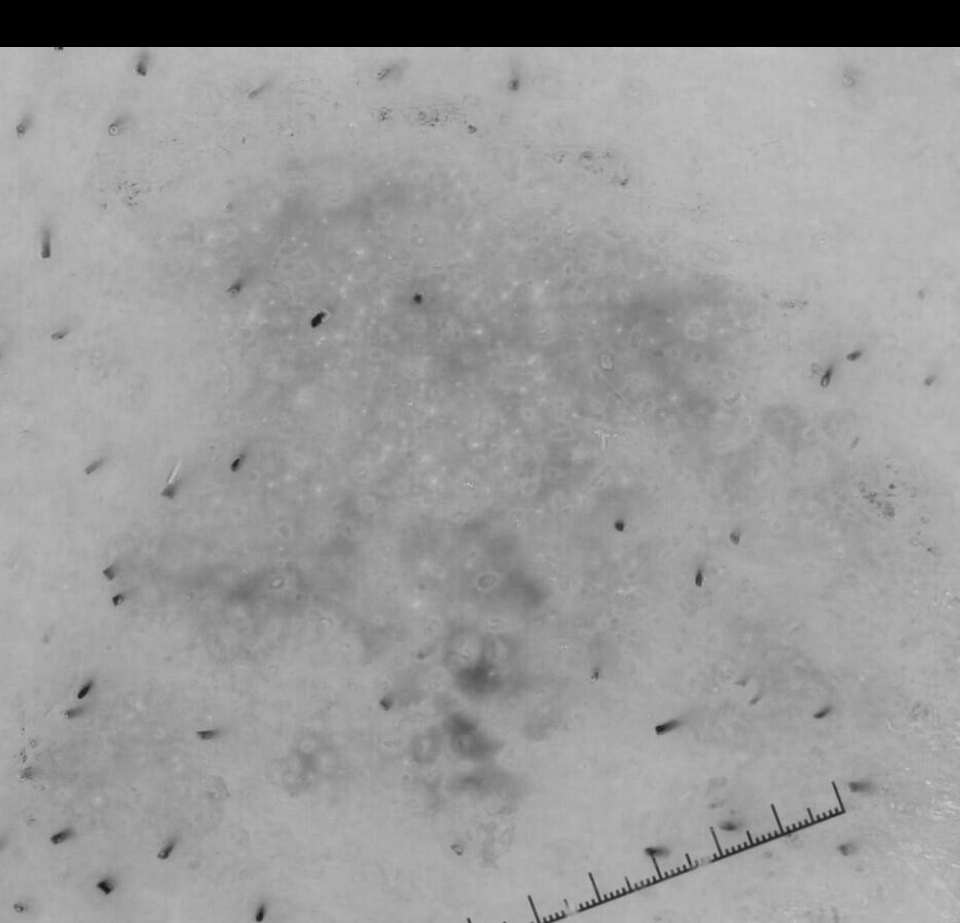

In [37]:
# import numpy as np, cv2, geojson


# ### I have to switch coordinate systems, which is why I need to multiple by -1



# def TileMap_to_SVG( tileImg ):
#     """
#     This function takes an input image as a PNG File and produces a pointlist of the
#     outer most contour for each label map, and produces a format I can read in as SVG for visualization"""
#     debug = False
    
#     # Load an color image in grayscale; currently not working with > 256 superpixels
#     img = cv2.imread(tileImg)
#     img_gray = img[:,:,2]

#     unique_labels = np.unique(img_gray)
#     if debug: print len(unique_labels)
            
#     #unique_labels = unique_labels[40:100]
#     all_cnts = []
#     cntdict = {}
#     return_data = []
#     ## So a given label/contour can contain one or more features...
    

#     ## Now iterate through each label, mask the input image with the label, and find appropriate contours
#     for label in unique_labels:
#         working_img = img_gray.copy()
#         working_img[working_img != label] = 0
        
#         ## can pass cv2.RETR_CCCOMP or RETR_EXTERNAL
#         contours, hierarchy = cv2.findContours(working_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) ## can also do CHAIN_APPROX_TC89_L1
        
#         if len(contours) > 4:
#             if debug: print "Found %d contours for label %s" % ( len(contours), label)

#             for c in contours:    
#             #print "Parsing label",label
#                 print np.squeeze( c )
#                 outerpoly = contourToSVGString( np.squeeze( c ) )
       
            
#                 all_cnts.append( { 'geometry': { 'type': 'polygon', 'coordinates': outerpoly }, 'properties' : { 'labelindex': str(label)    } } )
#         else:
#             print len(contours),"were found for label",label
      
#     for c in all_cnts:
#         #print c
#         return_data.append(geojson.dumps(c))
        
#     return return_data
### Should have 205 voxels
#Image(masked_img)
#Image
from PIL import Image as PILImage
img = cv2.imread(filename_url)
img_gray = img[:,:,2]

working_img = img_gray.copy()
PIL_Image.fromarray(working_img)
# img_gray = img[:,:,2]
# working_img = img_gray.copy()
# working_img[working_img != 24] = 0
# masked_img = Image.fromarray(working_img, 'RGB')
# PILImage.fromarray(working_img)

In [1]:
#print working_img
#Image(masked_img)
from matplotlib.pyplot import imshow
#Image
working_img = imgray.copy()
working_img[working_img != 120] = 0
#masked_img = Image.fromarray(working_img, 'RGB')
from PIL import Image as PILImage
#PILImage.fromarray(working_img)

NameError: name 'imgray' is not defined

In [150]:
print "image x",img_x
print "image y",img_y

tr = (img_x,0)
#imgray.shape  ## NO IDEA what 
bl = (0,img_y)

print tr,bl
native_width = tr[0] - bl[0]
native_height = -bl[1] + tr[1]

#native_width = 

# extent = opdata['extent']
# tr = extent[0]
# bl = extent[1]
# native_width = tr[0] - bl[0]
# native_height = -bl[1] + tr[1]

native_width = imgray.shape[0]
native_height = imgray.shape[1]
#img

image x 960
image y 923
(960, 0) (0, 923)


In [23]:
print imgray.shape
# ip._segmentConnectedRegionCV
import json  
with  open('data/data.geojson','w') as outfile:
    json.dump(return_data, outfile)

# ...skipping...
# def segmentationSourceHandler(item, params):
#     # todo : have it pull the appropriate annotation, it current pulls the last one

#     files = ModelImporter.model('item').childFiles(item, sort=[('created', pymongo.DESCENDING)])

#     for first_file in files:
#         if first_file['mimeType'] == 'image/png':
#             # this is a hack; we should use negative lookahead assertions instead
#             if re.search(r'-p1.\.png$', first_file['name']) and not re.search(r'-tile-p1.\.png$', first_file['name']):
#                 break
#     else:
#         raise RestException('No source PNG file in item')

#     file_download = ModelImporter.model('file').download(first_file, headers=True)
#     cherrypy.response.headers['Content-Disposition'] = 'inline; filename="%s"' % first_file['name']
#     return file_download

# segmentationSourceHandler.cookieAuth = True
# segmentationSourceHandler.description = (
#     Description('Retrieve segmentation source PNG image for a given image item.')
#     .param('item_id', 'The item ID', paramType='path')
#     .errorResponse())

(923, 960)
